In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import time
from keras_tuner import HyperModel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import GridSearchCV

In [2]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish_D1_I7000_F9000/TPath_500_finish_data_D1.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00199,500,7000,9000,675.83
2,0.0000,-0.00198,500,7000,9000,682.81
3,0.0000,-0.00197,500,7000,9000,689.82
4,0.0000,-0.00196,500,7000,9000,696.80
...,...,...,...,...,...,...
100646,0.0025,0.00196,500,7000,9000,578.47
100647,0.0025,0.00197,500,7000,9000,576.89
100648,0.0025,0.00198,500,7000,9000,575.32
100649,0.0025,0.00199,500,7000,9000,573.76


In [3]:
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.0000,-0.00200,669.05
1,0.0000,-0.00199,675.83
2,0.0000,-0.00198,682.81
3,0.0000,-0.00197,689.82
4,0.0000,-0.00196,696.80
...,...,...,...
100646,0.0025,0.00196,578.47
100647,0.0025,0.00197,576.89
100648,0.0025,0.00198,575.32
100649,0.0025,0.00199,573.76


In [4]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
83145       0.00207      -0.00062      1282.2
66701       0.00166      -0.00065      1347.6
91325       0.00227       0.00098      1094.6
46593       0.00116      -0.00123      1175.7
49518       0.00123      -0.00005      1459.2
...             ...           ...         ...
6265        0.00015       0.00050      1439.1
54886       0.00136       0.00150       876.7
76820       0.00191       0.00029      1335.8
860         0.00002      -0.00142      1071.2
15795       0.00039      -0.00044      1488.1

[100651 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00207,-0.00062,1282.2
1,0.00166,-0.00065,1347.6
2,0.00227,0.00098,1094.6
3,0.00116,-0.00123,1175.7
4,0.00123,-0.00005,1459.2
...,...,...,...
100646,0.00015,0.00050,1439.1
100647,0.00136,0.00150,876.7
100648,0.00191,0.00029,1335.8
100649,0.00002,-0.00142,1071.2


In [5]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [6]:
X.describe()

,X-Koordinate,Y-Koordinate
count,100651.000000,1.006510e+05
mean,0.001250,1.103042e-20
std,0.000725,1.157589e-03
min,0.000000,-2.000000e-03
25%,0.000620,-1.000000e-03
50%,0.001250,4.529900e-18
75%,0.001880,1.000000e-03
max,0.002500,2.000000e-03


In [7]:
y.describe()


count    100651.000000
mean       1144.030064
std         264.135723
min         572.200000
25%         937.330000
50%        1201.100000
75%        1368.700000
max        1520.000000
Name: Temperatur, dtype: float64

In [8]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [9]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [10]:
X_train_scaled

array([[0.416 , 0.5725],
       [0.812 , 0.7325],
       [0.628 , 0.5075],
       ...,
       [0.604 , 0.3875],
       [0.748 , 0.65  ],
       [0.028 , 0.6225]])

In [17]:
start_time = time.time()
# Netzwerkarchitektur
model = Sequential([
    # Eingabeschicht
    Dense(224, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(96, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
 
    Dense(224, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(352, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min', restore_best_weights=True)#, min_delta = 0.00005)

# Trainingsparameter
batch_size = 500
epochs = 200

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose = 1)

end_time = time.time()

# Berechne die Dauer
duration = end_time - start_time

print(f"Die Ausführungszeit betrug {duration} Sekunden.")

Epoch 1/200
129/129 [==============================] - 2s 6ms/step - loss: 0.2231 - mae: 0.1356 - val_loss: 0.1428 - val_mae: 0.0094
Epoch 2/200
129/129 [==============================] - 1s 5ms/step - loss: 0.1312 - mae: 0.0177 - val_loss: 0.1213 - val_mae: 0.0110
Epoch 3/200
129/129 [==============================] - 1s 5ms/step - loss: 0.1151 - mae: 0.0093 - val_loss: 0.1093 - val_mae: 0.0048
Epoch 4/200
129/129 [==============================] - 1s 5ms/step - loss: 0.1048 - mae: 0.0113 - val_loss: 0.1002 - val_mae: 0.0074
Epoch 5/200
129/129 [==============================] - 1s 5ms/step - loss: 0.0965 - mae: 0.0107 - val_loss: 0.0927 - val_mae: 0.0086
Epoch 6/200
129/129 [==============================] - 1s 5ms/step - loss: 0.0894 - mae: 0.0089 - val_loss: 0.0860 - val_mae: 0.0049
Epoch 7/200
129/129 [==============================] - 1s 5ms/step - loss: 0.0832 - mae: 0.0096 - val_loss: 0.0803 - val_mae: 0.0096
Epoch 8/200
129/129 [==============================] - 1s 6ms/step - 

In [18]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[1000]} Actual: {original_actual_values[1000]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")
    
    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]
    
    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)
    
    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")


 Bsp. Predicted: [1197.9163] Actual: [1195.9] 
Durchschnittliche Abweichung (MAE): [3.52265818]


In [20]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] < -10).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)
 
sorted_df

Anzahl der Werte die kleiner sind: 370


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
19281,773.464722,807.84,1.000,0.9125,-34.375278
14143,799.875488,832.75,1.000,0.9025,-32.874512
16514,806.433167,838.63,1.000,0.9000,-32.196833
4160,773.369629,805.35,0.992,0.9125,-31.980371
9896,760.146057,791.74,0.992,0.9175,-31.593943
...,...,...,...,...,...
9782,686.061401,665.99,0.920,0.0000,20.071401
7694,687.607117,667.48,0.944,0.0000,20.127117
11547,685.803589,665.34,0.916,0.0000,20.463589
1409,687.091919,666.57,0.936,0.0000,20.521919


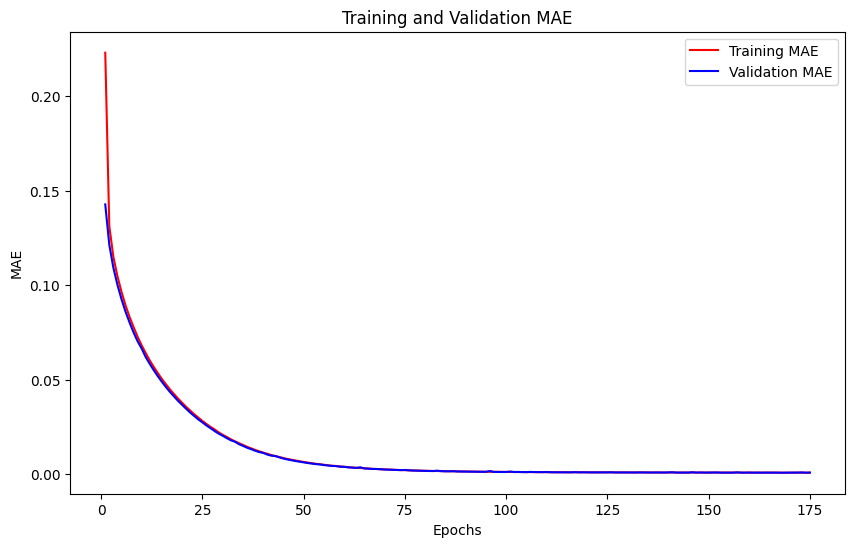

In [21]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)
# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


# GridSearch
Grid Search bietet die Vorteile der anpassbaren Rechenzeit sowie die Möglichkeit des EInsatzes von Verteilungen. So können theoretisch Hyperparamterkonfuigurationen gefunden wende, welche durch GridSearch nicht auffindbar wären. ZUdem ist das Ziel der Hyperparamteroptimierung eine Einstellung zu finden, welche auf Trainings und Testset gut angepasst ist. Die EInstellung muss nicht die bestmöglichste Einstellung sein, sondern eine Einstellung die das gewähltre Problem gut wiederspiegelt. 
Bayesian Optimierung

In [11]:
def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(224, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(32, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(96, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(224, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(128, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(352, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
model = KerasRegressor(model=build_model, verbose=2)

# Anpassung der Parameter im param_grid
param_grid = {
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'model__regularization': [0.001, 0.0001],
    'fit__batch_size': [50, 100, 200, 500],
    'fit__epochs': [30],
    'model__dropout_rate' : [0.0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# Beste Parameter und Score ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Beste Genauigkeit:", grid_search.best_score_)

with open("Gridsearch_D1.txt", "w") as f:
    f.write(f"Beste Parameter: {grid_search.best_params_}\n")
    f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Epoch 1/30
162/162 - 12s - loss: 0.1968 - mae: 0.0992 - 12s/epoch - 76ms/step
Epoch 2/30
162/162 - 1s - loss: 0.1165 - mae: 0.0120 - 1s/epoch - 7ms/step
Epoch 3/30
162/162 - 1s - loss: 0.1008 - mae: 0.0113 - 1s/epoch - 8ms/step
Epoch 4/30
162/162 - 2s - loss: 0.0900 - mae: 0.0098 - 2s/epoch - 10ms/step
Epoch 5/30
162/162 - 2s - loss: 0.0813 - mae: 0.0086 - 2s/epoch - 14ms/step
Epoch 6/30
162/162 - 3s - loss: 0.0740 - mae: 0.0100 - 3s/epoch - 17ms/step
Epoch 7/30
162/162 - 3s - loss: 0.0674 - mae: 0.0073 - 3s/epoch - 17ms/step
Epoch 8/30
162/162 - 3s - loss: 0.0617 - mae: 0.0081 - 3s/epoch - 19ms/step
Epoch 9/30
162/162 - 3s - loss: 0.0566 - mae: 0.0080 - 3s/epoch - 17ms/step
Epoch 10/30
162/162 - 3s - loss: 0.0520 - mae: 0.0070 - 3s/epoch - 17ms/step
Epoch 11/30
162/162 - 3s - loss: 0.0479 - mae: 0.0068 - 3s/epoch - 18ms/step
Epoch 12/30
162/162 - 3s - loss: 0.0442 - mae: 0.0072 - 3s/epoch - 18ms/step
Epoch 13/30
162/162 - 3

# Bayesian Optimization

In [16]:
from bayes_opt import BayesianOptimization


# Angenommene Daten
# X_train_scaled, y_train_scaled = # Deine skalierten Trainingsdaten

def train_evaluate(neurons_layer_1, neurons_layer_2, neurons_layer_3, neurons_layer_4, neurons_layer_5, learning_rate):
    model = Sequential([
        Dense(int(neurons_layer_1), activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_2), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_4), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_5), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        
        Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True, min_delta=0.0001)

    history = model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Hier wählen wir den negativen Mean Squared Error, da Bayesian Optimization maximiert
    mse = np.min(history.history['val_loss'])
    return -mse

# Definieren des Bereichs der Hyperparameter
pbounds = {
    'neurons_layer_1': (16, 200),
    'neurons_layer_2': (16, 200),
    'neurons_layer_3': (16, 200),
    'neurons_layer_4': (16, 200),
    'neurons_layer_5': (16, 200),
    'learning_rate': (0.0001, 0.01),
}

# Initialisieren des BayesianOptimization-Objekts
optimizer = BayesianOptimization(
    f=train_evaluate,
    pbounds=pbounds,
    random_state=1,
)

# Starten der Optimierung
optimizer.maximize(init_points=2, n_iter=20)

print(optimizer.max)


|   iter    |  target   | learni... | neuron... | neuron... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------
Restoring model weights from the end of the best epoch: 12.
Epoch 17: early stopping
| 1         | -0.000638 | 0.004229  | 148.5     | 16.02     | 71.63     | 43.0      | 32.99     |
Restoring model weights from the end of the best epoch: 14.
Epoch 19: early stopping
| 2         | -0.000562 | 0.001944  | 79.58     | 89.01     | 115.1     | 93.13     | 142.1     |
Restoring model weights from the end of the best epoch: 13.
Epoch 18: early stopping
| 3         | -0.000766 | 0.005658  | 85.07     | 104.1     | 119.3     | 41.35     | 134.6     |
Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping
| 4         | -0.000834 | 0.008647  | 85.11     | 86.15     | 110.5     | 103.4     | 144.2     |
Restoring model weights from the end of the best epoch: 15.
Epoch 20: ea

# Random Search Architektur

In [18]:
# Definieren der Funktion, die das Modell erstellt
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('input_units', min_value=32, max_value=512, step=32), input_shape=(2,), activation='relu'))
    # Hinzufügen von Schichten basierend auf dem Suchraum
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Erstellen des RandomSearch Objekts
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,  # Anzahl der zu testenden Modellkonfigurationen
    executions_per_trial=1,  # Anzahl der Male, die jede Modellkonfiguration trainiert wird
    directory='random_search',  # Verzeichnis zur Speicherung der Suchlogs
    project_name='neural_network_optimization'
)

# Durchführung des Random Search
tuner.search(X_train_scaled, y_train_scaled, epochs=20, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Abrufen des besten Modells
best_model = tuner.get_best_models(num_models=1)[0]

# Zusammenfassung des besten Modells
best_model.summary()

# Sie können auch die besten Hyperparameter direkt abrufen
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(best_hyperparameters.values) 

Trial 100 Complete [00h 00m 48s]
val_loss: 1.355679523840081e-05

Best val_loss So Far: 1.3108049188303994e-06
Total elapsed time: 01h 41m 02s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               672       
                                                                 
 dense_1 (Dense)             (None, 32)                7200      
                                                                 
 dense_2 (Dense)             (None, 96)                3168      
                                                                 
 dense_3 (Dense)             (None, 224)               21728     
                                                                 
 dense_4 (Dense)             (None, 128)               28800     
                                                                 
 dense_5 (Dense)             (None, 352)     